In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

import datetime as dt
from datetime import timedelta

from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
lc = LabelEncoder()

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error

from sklearn.pipeline import make_pipeline, Pipeline

from numpy import arange
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge


from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, make_scorer, recall_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, roc_auc_score

# Trick to widen the screen
from IPython.core.display import display, HTML

#Widens the code landscape 
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 50)
sns.set_style('whitegrid')

/var/folders/rk/3cjh1nsx2nq4f1s4lvbzsp480000gn/T/ipykernel_40057/152592234.py:39: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#pip install --upgrade seaborn matplotlib


This code block will put all of my data engineering that I did in my previous notebook into one block for the MasterQuote dataframe.  This will be. alarge comilation of previously commented code

In [39]:
#df_general reps general df
df_TheGeneral = pd.read_csv('Dataset/TheGeneral.csv', header = 0)

#first calculate percentage of nan in each column and 
#put that to variable nan_percentage
gen_nan_percentage = df_TheGeneral.isnull().mean() * 100

#now we drop columns where nan values are greater than 20%
general_cleaned = df_TheGeneral.loc[:, gen_nan_percentage <= 20]

#fill nan values for categorical columns with the mode
for column in general_cleaned.select_dtypes(include=['object']).columns:
    general_cleaned[column].fillna(general_cleaned[column].mode()[0], inplace=True)
    
    #fill nan values for numerical columns with the median
for column in general_cleaned.select_dtypes(include=['int64', 'float64']).columns:
    general_cleaned[column].fillna(general_cleaned[column].median(), inplace=True)
    
gen_object_columns = general_cleaned.select_dtypes(include=['object']).columns

# Count unique entries for each object column
gen_unique_counts = general_cleaned[gen_object_columns].nunique()

gen_cat = [col for col in gen_object_columns if col not in ['AbilitecContactID', 'AbilitecHouseholdID', 'PolicyNumber', 'ClaimNumber', 'TermEffectiveDate', 'PolicyStateCode', 'DateOfLoss', 'ClaimType']]

#generate dummy variables for all categprical columns in gen df
gen_encoded = pd.get_dummies(general_cleaned, columns=gen_cat, drop_first=False)

general_cleaned = gen_encoded

general_cleaned = general_cleaned.drop(columns=general_cleaned.select_dtypes(include=['object']).columns)

general_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11069 entries, 0 to 11068
Data columns (total 73 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   DriverNumber                               11069 non-null  int64  
 1   DriverCount                                11069 non-null  int64  
 2   ClaimCount                                 11069 non-null  int64  
 3   TotalPaid                                  11069 non-null  float64
 4   DriverID                                   11069 non-null  int64  
 5   VehicleID                                  11069 non-null  int64  
 6   ClaimTransCount                            11069 non-null  float64
 7   ClaimTransPaidLoss                         11069 non-null  float64
 8   DaysToClaim                                11069 non-null  float64
 9   DaysToClaim_h                              11069 non-null  float64
 10  AtFaultDescription_Com

## Creating a Target Variable
ClaimCount and TotalPaid:

ClaimCount: The number of claims a driver has made.
TotalPaid: The total amount paid for the claims.
Customers with a high number of claims or large total payments may be considered high risk.
ClaimTransCount and ClaimTransPaidLoss:

ClaimTransCount: The number of transactions related to a claim.
If the customer has high trans count, they could be flagged as high risk.

DaysToClaim: The number of days between the policy start and the claim. Customers who file claims shortly after the policy starts may be flagged as high risk (e.g., opportunistic behavior).

AtFaultDescription columns:
AtFaultDescription_Comparative Negligence,AtFaultDescription_Fault unknown, AtFaultDescription_Insured at fault, AtFaultDescription_No fault, AtFaultDescription_Other party at fault

These describe who was at fault for the claim. If the insured driver is at fault more often, they may be more likely to be a high-risk customer.


These are my parameters to determine a high risk customer

In [40]:
high_risk = []

claim_count_median = general_cleaned["ClaimCount"].median()
total_paid_median = general_cleaned["TotalPaid"].median()
claim_trans_count_median = general_cleaned["ClaimTransCount"].median()
days_to_claim_threshold = 30  # Days to claim is less than 30
at_fault_condition = (general_cleaned["AtFaultDescription_Insured at fault"] == 1) | \
                     (general_cleaned["AtFaultDescription_Fault unknown"] == 1)

for index, row in general_cleaned.iterrows():
    conditions_met = 0

    # Check each condition
    if row["ClaimCount"] > claim_count_median:
        conditions_met += 1
    if row["TotalPaid"] > total_paid_median:
        conditions_met += 1
    if row["ClaimTransCount"] > claim_trans_count_median:
        conditions_met += 1
    if row["DaysToClaim"] < days_to_claim_threshold:
        conditions_met += 1
    if at_fault_condition.iloc[index]:  # Check if the driver is at fault
        conditions_met += 1

    # If at least two conditions are met, consider the customer high risk
    if conditions_met >= 4:
        high_risk.append(1)
    else:
        high_risk.append(0)

# Add the high_risk column to the DataFrame
general_cleaned["high_risk"] = high_risk

# Display the first few rows
general_cleaned.head(20)


,DriverNumber,DriverCount,ClaimCount,TotalPaid,DriverID,VehicleID,ClaimTransCount,ClaimTransPaidLoss,DaysToClaim,DaysToClaim_h,AtFaultDescription_Comparative Negligence,AtFaultDescription_Fault unknown,AtFaultDescription_Insured at fault,AtFaultDescription_No fault,AtFaultDescription_Other party at fault,ClaimStatus_C,ClaimStatus_O,LossState_AK,LossState_AL,LossState_AR,LossState_AZ,LossState_CA,LossState_CO,LossState_CT,LossState_DC,LossState_DE,LossState_FL,LossState_FM,LossState_GA,LossState_HI,LossState_IA,LossState_ID,LossState_IL,LossState_IN,LossState_KS,LossState_KY,LossState_LA,LossState_MA,LossState_MD,LossState_ME,LossState_MI,LossState_MN,LossState_MO,LossState_MS,LossState_MT,LossState_NC,LossState_ND,LossState_NE,LossState_NH,LossState_NJ,LossState_NM,LossState_NV,LossState_NY,LossState_OH,LossState_OK,LossState_ON,LossState_OR,LossState_PA,LossState_RI,LossState_SC,LossState_SD,LossState_TN,LossState_TX,LossState_UT,LossState_VA,LossState_VI,LossState_VT,LossState_WA,LossState_WI,LossState_WV,LossState_WY,SubrogrationFlag_NO,SubrogrationFlag_YES,high_risk
0,1,4,1,5086.61,98,1,9.0,5086.61,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,2,1,0.00,1,1,4.0,0.00,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,2,1,21397.74,1,1,53.0,21397.74,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,5,3,0.00,98,2,14.0,0.00,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,5,3,0.00,1,2,1.0,0.00,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,1,5,3,0.00,1,4,8.0,0.00,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,1,1,1,0.00,1,1,1.0,0.00,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,1,4,2,139.90,1,1,6.0,69.95,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,1,4,2,139.90,1,1,6.0,69.95,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,1,2,1,1437.07,1,1,6.0,1437.07,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


this code will show us the number of high risk customers vs not. 1 being high risk 0 being not

In [42]:
# Count the number of rows for each high_risk category
high_risk_counts = general_cleaned["high_risk"].value_counts()

# Display the counts
print(high_risk_counts)

0    7203
1    3866
Name: high_risk, dtype: int64


This cell will show us unique values

In [43]:
# Display all unique values in the 'DaysToClaim' column
unique_values = general_cleaned['DaysToClaim'].unique()

# Print the unique values
print("Unique values in 'DaysToClaim':")
print(unique_values)

Unique values in 'DaysToClaim':
[ 0.00000000e+00  1.48000000e+02  1.00000000e+01  3.00000000e+01
  1.30000000e+01  1.50000000e+01  6.40000000e+01  1.80000000e+01
  5.41666667e-01  6.25000000e-01  6.97916667e-01  5.00000000e-01
  9.23611111e-01  7.50000000e-01  6.66666667e-01  5.20833333e-01
  7.70833333e-01  4.47916667e-01  4.79166667e-01  4.89583333e-01
  6.94444444e-04  6.56250000e-01  4.72222222e-01  7.22222222e-01
  1.80555556e-01  5.11805556e-01  3.43750000e-01  5.93750000e-01
  7.29166667e-01  4.37500000e-01  3.52777778e-01  8.95833333e-01
  6.77083333e-01  6.87500000e-01  5.27777778e-01  7.36111111e-01
  7.29166667e-02  8.12500000e-01  4.16666667e-01  6.45833333e-01
  2.00000000e+00  2.29166667e-01  8.75000000e-01  4.58333333e-01
  7.12500000e-01  1.00000000e+00  1.10000000e+01  6.00000000e+00
  2.70000000e+02  3.10000000e+01  1.53000000e+02  4.00000000e+00
  8.00000000e+00  5.60000000e+01  2.00000000e+01  2.50000000e+01
  5.00000000e+00  2.10000000e+01  3.20000000e+01  4.200000

## Creating Test/Train Data split
- split data into training (70%) and testing (30%)
* general_cleaned includes features and a target dsataset
* create X dataset (only includes features)
* create y dataset (only includes target variable) (high risk)
* creating train and test datasets for X and y

- then I will scale the data using standard scaler

In [49]:
# create var for target variable
target_var = "high_risk"

#definng features(x) and target(y)
X = general_cleaned.drop(target_var, axis = 1)
y = general_cleaned[target_var]


# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

This cell will ensure that we have even class distribution

In [50]:
#Checking Class Distribution
print("\nClass Distribution in Original Data:")
print(y.value_counts(normalize=True))
print("\nClass Distribution in Training Data:")
print(y_train.value_counts(normalize=True))
print("\nClass Distribution in Test Data:")
print(y_test.value_counts(normalize=True))


Class Distribution in Original Data:
0    0.650736
1    0.349264
Name: high_risk, dtype: float64

Class Distribution in Training Data:
0    0.650749
1    0.349251
Name: high_risk, dtype: float64

Class Distribution in Test Data:
0    0.650708
1    0.349292
Name: high_risk, dtype: float64


Apply standard scaler and show the training set and test set size

In [51]:
#standard scaler
sc = StandardScaler()

# Scale using NumPy arrays
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Convert to DataFrames only when needed (e.g., for interpretation or feature selection)
X_train_scaled_df = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_sc, columns=X_test.columns)

# Print Dataset Sizes
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 7748
Test set size: 3321


## Logistic Regression Model
* I will now create a logistic regression model for my first classification model
* I will do this using grid search to find the best fit model

In [16]:
#defining grid
grid = {
    "C": np.logspace(-3, 1, 10),
    "penalty": ["l1", "l2"],  # Penalty norm for regularization
    "class_weight": [None, 'balanced', {0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:2.5}, {0:1, 1:3}, {0:1, 1:5}],  # Class weight options
    "solver": ['lbfgs', 'liblinear']  # Solver options
}

#initialing a logistic regression model with spec random state
logreg = LogisticRegression(class_weight='balanced', random_state=21, max_iter = 25000)

#initialing grid search w log regression, using 10-fold cross validation
logreg_cv = GridSearchCV(logreg, grid, cv=3, n_jobs = -1) #, scoring = scoring)#, refit = 'accuracy')

# Fit the GridSearchCV object to the training data
logreg_cv.fit(X_train_sc, y_train)

# Print the best hyperparameters found during the search
print("Tuned hyperparameters: (best parameters)", logreg_cv.best_params_)

Tuned hyperparameters: (best parameters) {'C': 0.05994842503189409, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


Taking best parameters and implementingt them into the logistic regression to ensure best model

In [52]:
# Set the model properties based on the specified configuration
best_lr = LogisticRegression(random_state=21,       # Set the random state for reproducibility
                            C=0.05994842503189409,                # Regularization parameter
                            class_weight= None,  # Class weights to handle class imbalance
                            penalty='l1',         # Penalty norm for regularization
                            solver='liblinear'    # Solver for optimization
                           )

best_lr.fit(X_train_sc, y_train)
#variable for best logistic regression model
best_lr_pred = best_lr.predict(X_test_sc)
lr_pred_proba = best_lr.predict_proba(X_test_sc)[:, 1]

## Reporting the Test Statistics
* This section will report the accuracy score, sensitivity, specificity and ROC AUC. Along with a classification report and a simple confusion matrix

In [53]:
#Evaluating the model and calculating the metrics
lr_accuracy = accuracy_score(y_test, best_lr_pred)
lr_conf_matrix = confusion_matrix(y_test, best_lr_pred)
lr_tn, lr_fp, lr_fn, lr_tp = lr_conf_matrix.ravel()
lr_sensitivity = lr_tp / (lr_tp + lr_fn)  # True Positive Rate (Recall)
lr_specificity = lr_tn / (lr_tn + lr_fp)  # True Negative Rate
lr_roc_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"Accuracy: {lr_accuracy:.2f} \n")
print(f"Sensitivity (Recall): {lr_sensitivity:.2f} \n")
print(f"Specificity: {lr_specificity:.2f} \n")
print(f"ROC AUC: {lr_roc_auc:.2f} \n")

print("Confusion Matrix:")
print(lr_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, best_lr_pred))

Accuracy: 0.90 

Sensitivity (Recall): 0.81 

Specificity: 0.95 

ROC AUC: 0.95 

Confusion Matrix:
[[2043  118]
 [ 220  940]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2161
           1       0.89      0.81      0.85      1160

    accuracy                           0.90      3321
   macro avg       0.90      0.88      0.89      3321
weighted avg       0.90      0.90      0.90      3321



## Analyzing Test Statistics
* I will assess the models accuracy, sensitivity and specificity

#### Accuracy
* 0.90
    * Accuracy measures the proportion of correctly classified instances (both true positives and true negatives) out of all instances.  It is basically a ratio of correct preditions to the total number of predictions made
* In relation to this model, an accuracy of .90 means that 90% of the total predictions made by the logistic regression model are correct, whether the instance is positive or nagative.  This is generally a strong result.

#### Sensitivity (Recall)
* 0.81
    * Sensitivity measures the proportion of actual positive instances (high_risk) that are correctly identified by the model. In reference to a logistic regression model, sensitivity tells us how well the model identifies the true positives.
* A sensitivity of 0.81 means that 81% of the actual positive instances (high_risk) are correctly identified as positive by the logistic regression model. This indicates that the model is relatively good at identifying positive cases.

#### Specificity
* 0.95
    * Specificity measures the proportion of actual negative instances (low risk) that are correctly identofied as negative by the model. This statistic plays a vital role in insuring that we correctly identify negative cases and minimize false positives.
* A specificity of 0.95 means that 95% of the actual negative instances (low risk) are correctly identified as negaive. This shows that the logistic regression model is very good at correctly identifying instances where the outcome is negative.

## Significant Features
* I will now assess important features by getting the absolute value of coefficients, then printinb them in descending order

In [54]:
# Extract feature importance and sort by absolute value of coefficients
lr_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_lr.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Print the sorted importance
print("Predictor Importance:")
print(lr_importance)

Predictor Importance:
                                Feature  Coefficient
6                       ClaimTransCount     1.620313
12  AtFaultDescription_Insured at fault     1.311290
2                            ClaimCount     1.148833
7                    ClaimTransPaidLoss     0.835880
3                             TotalPaid     0.438798
..                                  ...          ...
33                         LossState_IN     0.000000
32                         LossState_IL     0.000000
30                         LossState_IA     0.000000
29                         LossState_HI     0.000000
36                         LossState_LA     0.000000

[73 rows x 2 columns]


plotting the top 20 significant predictors

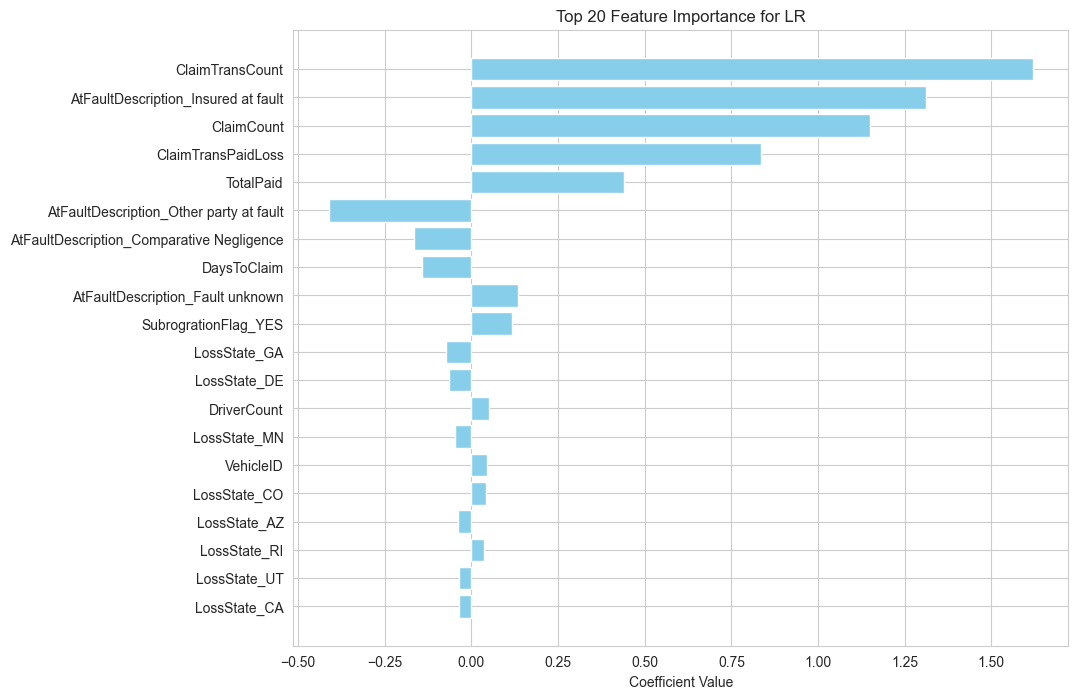

In [55]:
# Select the top 20 features
top_20 = lr_importance.head(20)

# Plotting the top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_20['Feature'], top_20['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Importance for LR')
plt.gca().invert_yaxis()  # To display the highest coefficients at the top
plt.show()

* We can see that the top 5 most significant predictors for the Logistic Regression Model is ClaimTransCount, Insured at fault, claim count, Claim Trans paid Loss, and total paid

## Visualization
* Here I will visulaize the Confusion Matrix and the ROC curve

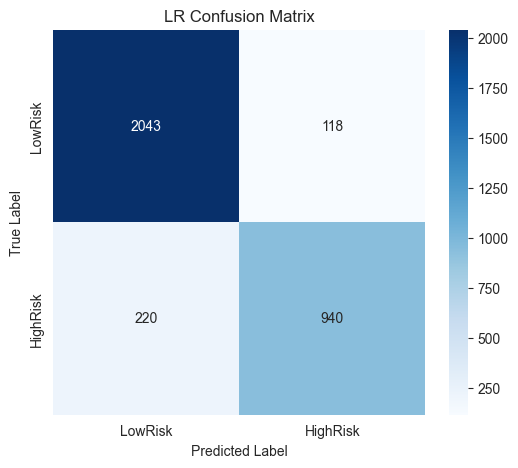

In [56]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["LowRisk", "HighRisk"], yticklabels=["LowRisk", "HighRisk"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LR Confusion Matrix")
plt.show()

This cell will create an ROC curve

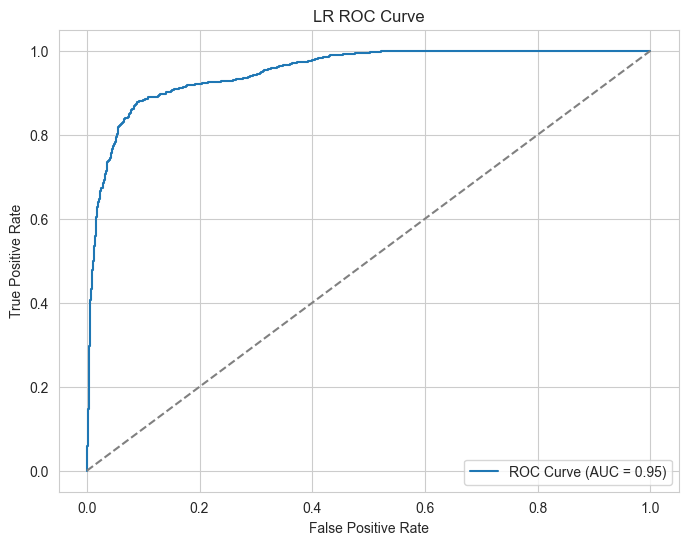

In [57]:
# Plot the ROC curve
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f"ROC Curve (AUC = {lr_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LR ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Decision Tree Model
* I will now create a decision tree model for my second classification model
* I will do this using grid search to find the best fit model

In [24]:
#set up the grid of parameters for decision tree model
grid={"criterion": ['gini', 'entropy'], #
      "max_depth" : [None, 2, 3, 4, 5, 6, 7, 8, 9],#
      "max_leaf_nodes" : [None,  8, 9, 10, 11, 12, 15, 20, 25, 30],
      "class_weight": [None, 'balanced', {0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:3}]}
dt_model = DecisionTreeClassifier(random_state = 21)
dt_model_cv=GridSearchCV(dt_model, grid, cv=5)
dt_model_cv.fit(X_train, y_train)

#print best parameters
print("tuned hyperparameters :(best parameters) ", dt_model_cv.best_params_)
# print("accuracy :",dt_model_cv.best_score_)


tuned hyperparameters :(best parameters)  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None}


creating best fit decision tree model based on the parameters from grid search

In [58]:
best_dt = DecisionTreeClassifier(max_depth = 3, max_leaf_nodes = None, 
                               class_weight='balanced', criterion = 'gini', random_state = 21)
best_dt.fit(X_train, y_train)
best_dt_pred = best_dt.predict(X_test)
dt_pred_proba = best_dt.predict_proba(X_test)[:, 1]

print(best_dt_pred)

# model_pred = pd.DataFrame(model_dt_pred)
# model_pred = model_pred.rename(columns = {0:'Predict_BestTree'})


# display(model_pred.sample(5, random_state=244))

[1 0 1 ... 1 0 0]


## Reporting the Test Statistics
* This section will report the accuracy score, sensitivity, specificity and ROC AUC. Along with a classification report and a simple confusion matrix

In [59]:
#Evaluating the model and calculating the metrics
dt_accuracy = accuracy_score(y_test, best_dt_pred)
dt_conf_matrix = confusion_matrix(y_test, best_dt_pred)
dt_tn, dt_fp, dt_fn, dt_tp = dt_conf_matrix.ravel()
dt_sensitivity = dt_tp / (dt_tp + dt_fn)  # True Positive Rate (Recall)
dt_specificity = dt_tn / (dt_tn + dt_fp)  # True Negative Rate
dt_roc_auc = roc_auc_score(y_test, dt_pred_proba)

print(f"Accuracy: {dt_accuracy:.2f} \n")
print(f"Sensitivity (Recall): {dt_sensitivity:.2f} \n")
print(f"Specificity: {dt_specificity:.2f} \n")
print(f"ROC AUC: {dt_roc_auc:.2f} \n")

print("Confusion Matrix:")
print(dt_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, best_dt_pred))

Accuracy: 0.93 

Sensitivity (Recall): 1.00 

Specificity: 0.89 

ROC AUC: 0.98 

Confusion Matrix:
[[1917  244]
 [   3 1157]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2161
           1       0.83      1.00      0.90      1160

    accuracy                           0.93      3321
   macro avg       0.91      0.94      0.92      3321
weighted avg       0.94      0.93      0.93      3321



## Analyzing Test Statistics
* I will assess the models accuracy, sensitivity and specificity

#### Accuracy
* 0.93
    * Accuracy measures th eproportion of correctly classified instances out of all instances. It helps tp provide an overall measure of how well the model performs on an entire dataset
* In relation to the decision tree model, an accuracy of 0.93 indicates that the decision tree model correctly classifies 93% of all cases.  This is a strong result and suggest that the model is performing very well overall

#### Sensitivity
* 1.00
    * Sensitivity measures the proportion of actual positive instances that the model correctly identifies as positive.
* In relation to this model, a sensitivity of 1.00 means the decision tree correctly identifies 100% of the positove cases.  This is perfect sensitivity score, indicating that there are no false negatives. This is crucial in scenarios where missing a positive case could have severe consequences.

#### Specificity
* 0.89
    * Specificity measures the proportion of actual negative instances that the model correctly identifies as negative
* A specificity of 0.89 indicates that the decision tree correctly identifies 89% of negative cases. However it also means that 11% of the negative vasesare incorrectly classified as positive. This is lower than the model sensitivity whihc shows that the model prioritizes capturing positives over minimizing false positives.

## Decision Tree Visualization
* I will now visualize the decision tree.  Because I used gridsearch immediately instead of doing a base decision tree then doing grid search, this visualization will be the pruned tree because I am only displaying the best fit model through gridsearch for each model.
* This will also help us determine the significant predictors for the decision tree

Pruned Decision Tree: 


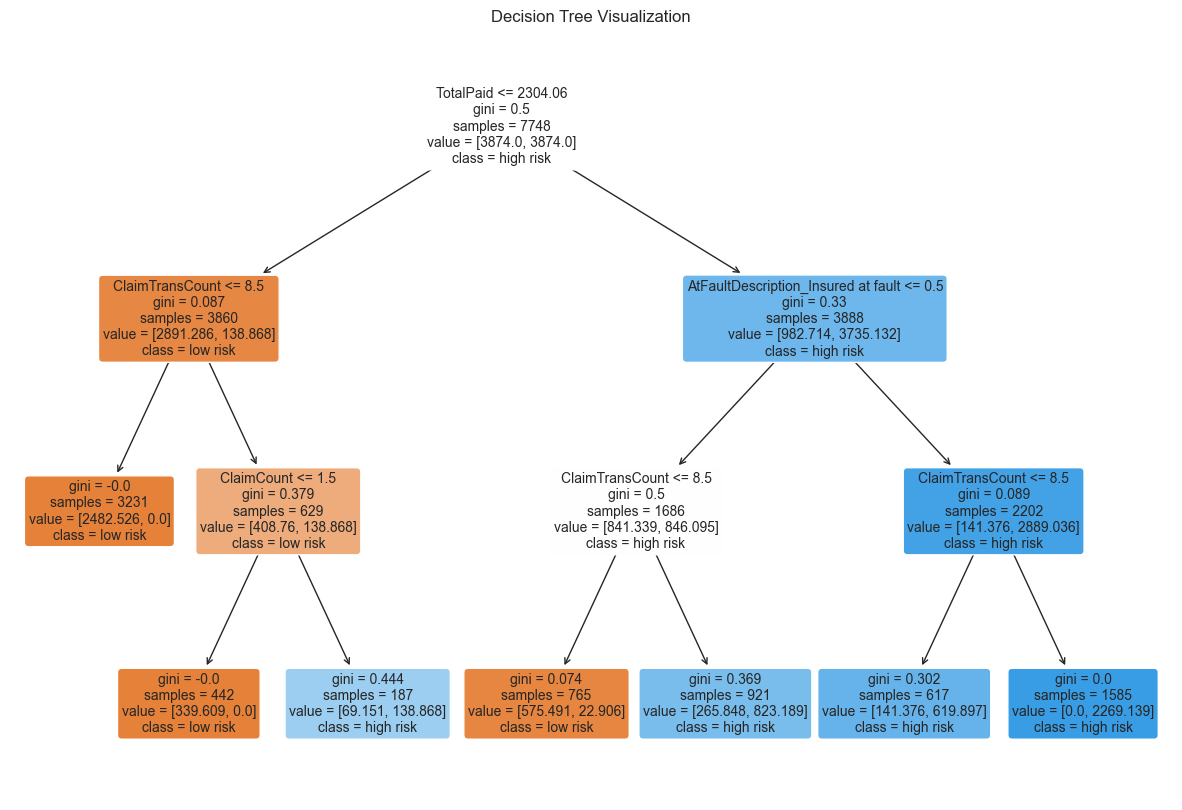

In [60]:
print("Pruned Decision Tree: ")
plt.figure(figsize=(15, 10))  # Adjust the size as needed
plot_tree(
    best_dt, 
    feature_names=list(X_train.columns),  # Convert Index to list
    class_names=['low risk', 'high risk'],  # Replace with your actual class labels
    filled=True,  # Color the nodes based on the class
    rounded=True,  # Make the boxes rounded
    fontsize=10  # Adjust font size for readability
)
plt.title("Decision Tree Visualization")
plt.show()


* We can see that the 4 significant predictors for the decision tree model were TotalPaid, ClamTransCount, Insured at fault, and Claim count

## Visualization
* Here I will visualize the Confusion Matrix and the ROC curve

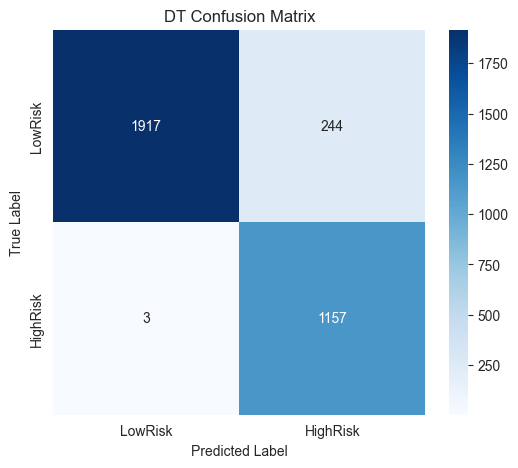

In [61]:
#plotting confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(dt_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["LowRisk", "HighRisk"], yticklabels=["LowRisk", "HighRisk"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("DT Confusion Matrix")
plt.show()

This cell will create an ROC Curve

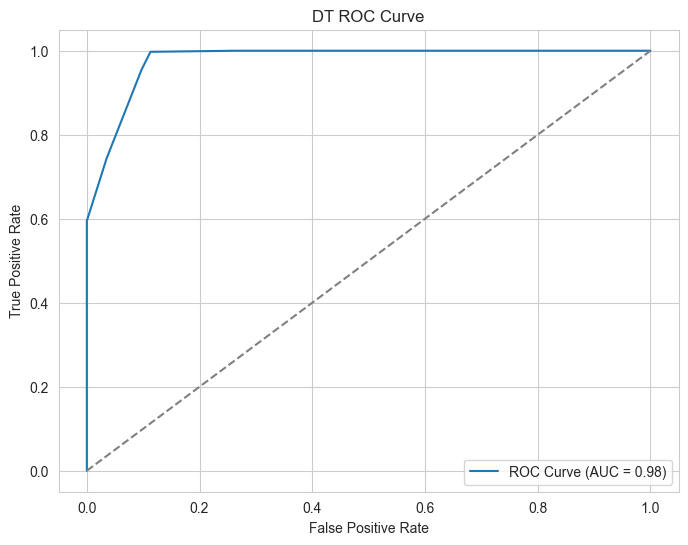

In [62]:
# Plot the ROC curve
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, label=f"ROC Curve (AUC = {dt_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DT ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Random Forest Model
* I will now create a random forest model for my third classification model
* I will do this using grid search to find the best fit model

In [30]:
#set up param grid
param_grid_rf = [
    {"criterion": ['gini', 'entropy'], #default is gini
     "max_features":['sqrt', 'log2'], #default is sqrt
    "n_estimators":[100, 500, 1000, 1500], #default is 100
     "max_depth" :[ None, 2, 3, 4, 5, 6, 7], #default is None
     "min_samples_leaf":[1, 5, 8, 12, 14, 16, 18, 20] #default is 1
    }
]

#make rf model
rf_model = RandomForestClassifier(random_state=21)

#set up grid search
rf_model_cv = GridSearchCV(rf_model, param_grid_rf, cv = 3, n_jobs=-1)

rf_model_cv.fit(X_train, y_train)

#print best parameters
print("tuned hyperparameters :(best parameters) ", rf_model_cv.best_params_)


tuned hyperparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}


fit model with best params

In [63]:
#best fit model will be called model_rf
best_rf = RandomForestClassifier(max_depth = 3, max_features='sqrt', min_samples_leaf=1, 
                                criterion = 'entropy', n_estimators = 1000, random_state = 21)
best_rf.fit(X_train, y_train)
best_rf_pred = best_rf.predict(X_test)
rf_pred_proba = best_rf.predict_proba(X_test)[:, 1]

print(best_rf_pred)

[1 0 1 ... 0 0 0]


## Reporting the Test Statistics
* This section will report the accuracy score, sensitivity, specificity and ROC AUC. Along with a classification report and a simple confusion matrix

In [64]:
#Evaluating the model and calculating the metrics
rf_accuracy = accuracy_score(y_test, best_rf_pred)
rf_conf_matrix = confusion_matrix(y_test, best_rf_pred)
rf_tn, rf_fp, rf_fn, rf_tp = rf_conf_matrix.ravel()
rf_sensitivity = rf_tp / (rf_tp + rf_fn)  # True Positive Rate (Recall)
rf_specificity = rf_tn / (rf_tn + rf_fp)  # True Negative Rate
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Accuracy: {rf_accuracy:.2f} \n")
print(f"Sensitivity (Recall): {rf_sensitivity:.2f} \n")
print(f"Specificity: {rf_specificity:.2f} \n")
print(f"ROC AUC: {rf_roc_auc:.2f} \n")

print("Confusion Matrix:")
print(rf_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, best_rf_pred))

Accuracy: 0.93 

Sensitivity (Recall): 0.82 

Specificity: 0.99 

ROC AUC: 0.98 

Confusion Matrix:
[[2149   12]
 [ 205  955]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2161
           1       0.99      0.82      0.90      1160

    accuracy                           0.93      3321
   macro avg       0.95      0.91      0.92      3321
weighted avg       0.94      0.93      0.93      3321



## Analyzing Test Statistics
* I will assess the models accuracy, sensitivity and specificity

#### Accuracy
* 0.93
    * Accuracy measures the overall correctness of the model, calculated as the ratio of correctly classified instances to the total number of instances
* In this case an accuracy of 0.93 means that the model correctly identifies 93% of the data. This is a very high and speaks to the model's ability to predict the data

#### Sensitivity
* 0.82
    * Sensitivity measures the model's ability to correctly identify positive instances (high risk customers). It focuses on the proportion of true positives out of all positives
* In this case a sensitivity of 0.82 means that the model correctly identifies 82% of all actual positive cases.  This is particulary important in scnenarios where missing a positive case is costly, such as flagging hogh-risk customers for an insurance company

#### Specificity
* 0.99
    * Specificity measures the model's ability to correctly identify negative instances. It focuses on the proportion of true negatives out of all actual negatives.
* In the case of this random forest model, a specificity of 0.99 means that the model correctly identified 99% of all actual negative cases. This indicates that the model is very good at recognizing low-risk customers. In turn, this would minimize false positives (low risk customers being flagged as high risk.

## Significant Features
* I will now assess important features by finding significant predictors, then printinb them in descending order

In [65]:
#this will show me my important features
feat_imp = pd.DataFrame(best_rf.feature_importances_)
names = pd.DataFrame(list(X.columns))
df_feat_imp = pd.concat([feat_imp, names], axis = 1)
df_feat_imp.columns = ['Importance', 'Features']
df_feat_imp.sort_values('Importance', ascending = False)

,Importance,Features
3,0.222084,TotalPaid
6,0.185308,ClaimTransCount
7,0.174324,ClaimTransPaidLoss
12,0.120847,AtFaultDescription_Insured at fault
2,0.089217,ClaimCount
...,...,...
42,0.000005,LossState_MO
44,0.000003,LossState_MT
27,0.000002,LossState_FM
29,0.000000,LossState_HI


create visualization

<Figure size 1000x1500 with 0 Axes>

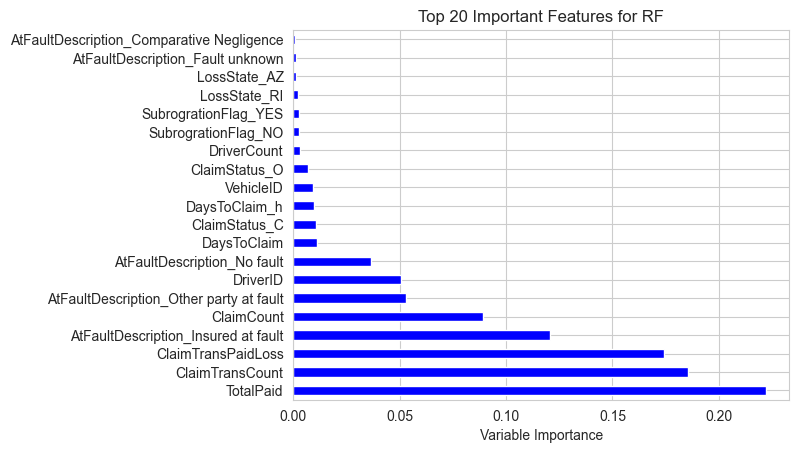

In [66]:
# Create a DataFrame for feature importances
rf_importance = pd.DataFrame({'Importance': best_rf.feature_importances_}, index=X.columns)

# Sort the feature importances in descending order to get the top features
rf_importance = rf_importance.sort_values('Importance', axis=0, ascending=False)

# Select the top 20 most important features
rf_top_20_importance = rf_importance.head(20)

# Set the figure size to make the plot taller, improving readability
plt.figure(figsize=(10, 15))  # Width=10, Height=15 for a tall plot

# Plot the feature importances as a horizontal bar chart
rf_top_20_importance.plot(kind='barh', color='b', linewidth=1)

# Set the x-label for the plot
plt.xlabel('Variable Importance')

# Remove the legend as it's unnecessary for this plot
plt.gca().legend_ = None

# Set the title for the plot
plt.title('Top 20 Important Features for RF')

# Display the plot
plt.show()

* We can see that the top 5 most important features for the Random Forest model in order are: TotalPaid, ClaimTransCount, ClaimTransPaidLoss, Insured at fault, and Claim count

## Visualization
* Here I will visualize the Confusion Matrix and the ROC curve

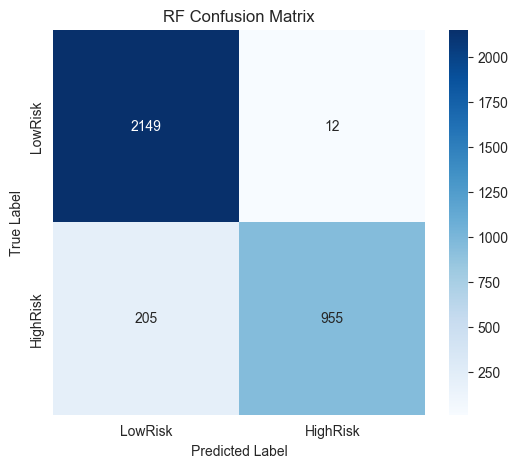

In [67]:
#plotting confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["LowRisk", "HighRisk"], yticklabels=["LowRisk", "HighRisk"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("RF Confusion Matrix")
plt.show()

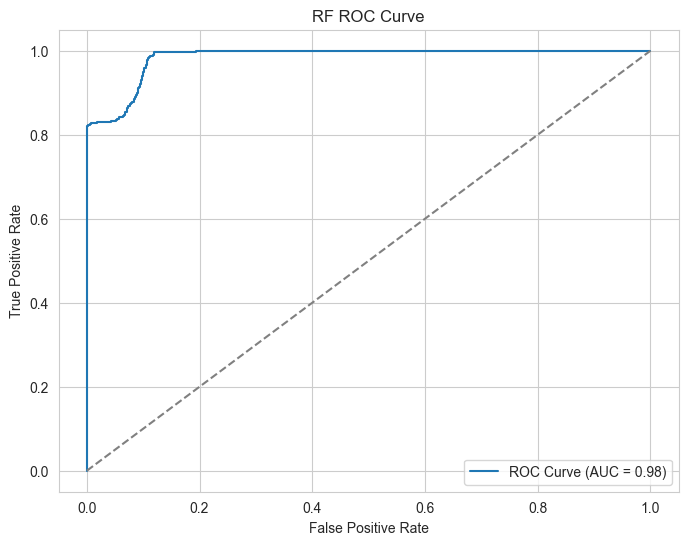

In [68]:
# Plot the ROC curve
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f"ROC Curve (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RF ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Comparison of Models
* here I will make a comparison ROC graph, decision matrix, and a bar chart comparing the accuracy, sensitivity, & specivity

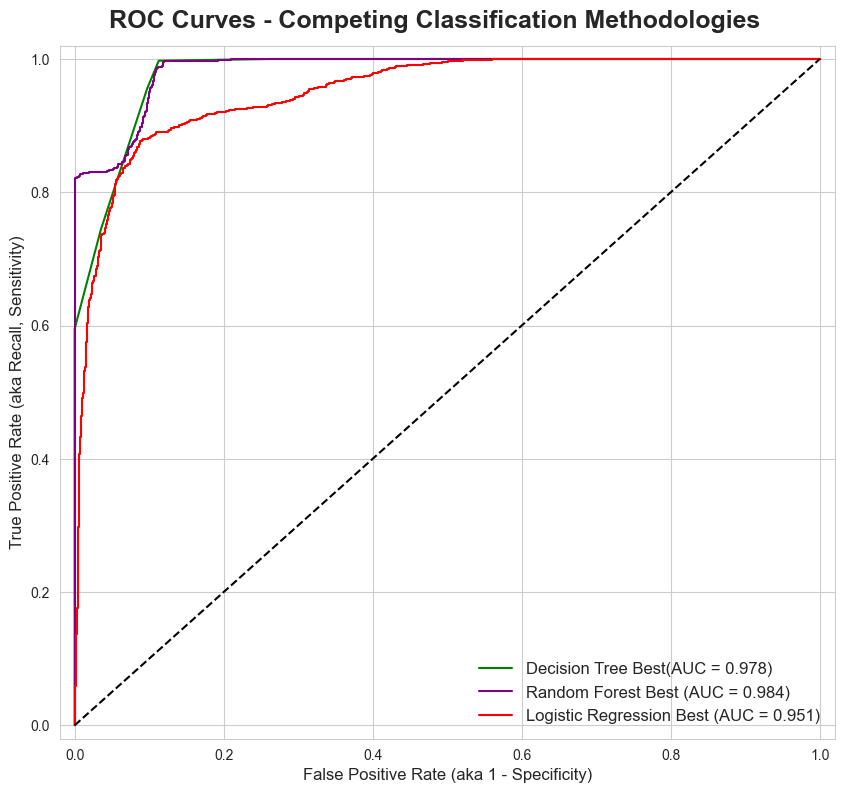

In [69]:
# Create the composite ROC curves
plt.figure(figsize = (10,9))
plt.suptitle('ROC Curves - Competing Classification Methodologies', fontweight='bold', fontsize=18, y=.92)

plt.plot(dt_fpr, dt_tpr, color='green',
         label='Decision Tree Best(AUC = {:.3f})'.format(dt_roc_auc))
plt.plot(rf_fpr, rf_tpr, color='purple', 
         label='Random Forest Best (AUC = {:.3f})'.format(rf_roc_auc))
plt.plot(lr_fpr, lr_tpr,color='red', 
         label='Logistic Regression Best (AUC = {:.3f})'.format(lr_roc_auc))

plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate (aka 1 - Specificity)', fontsize=12) 
plt.ylabel('True Positive Rate (aka Recall, Sensitivity)', fontsize=12)  
plt.legend(loc="lower right", frameon=False, fontsize=12)
plt.show()

this code will show all decision matrix

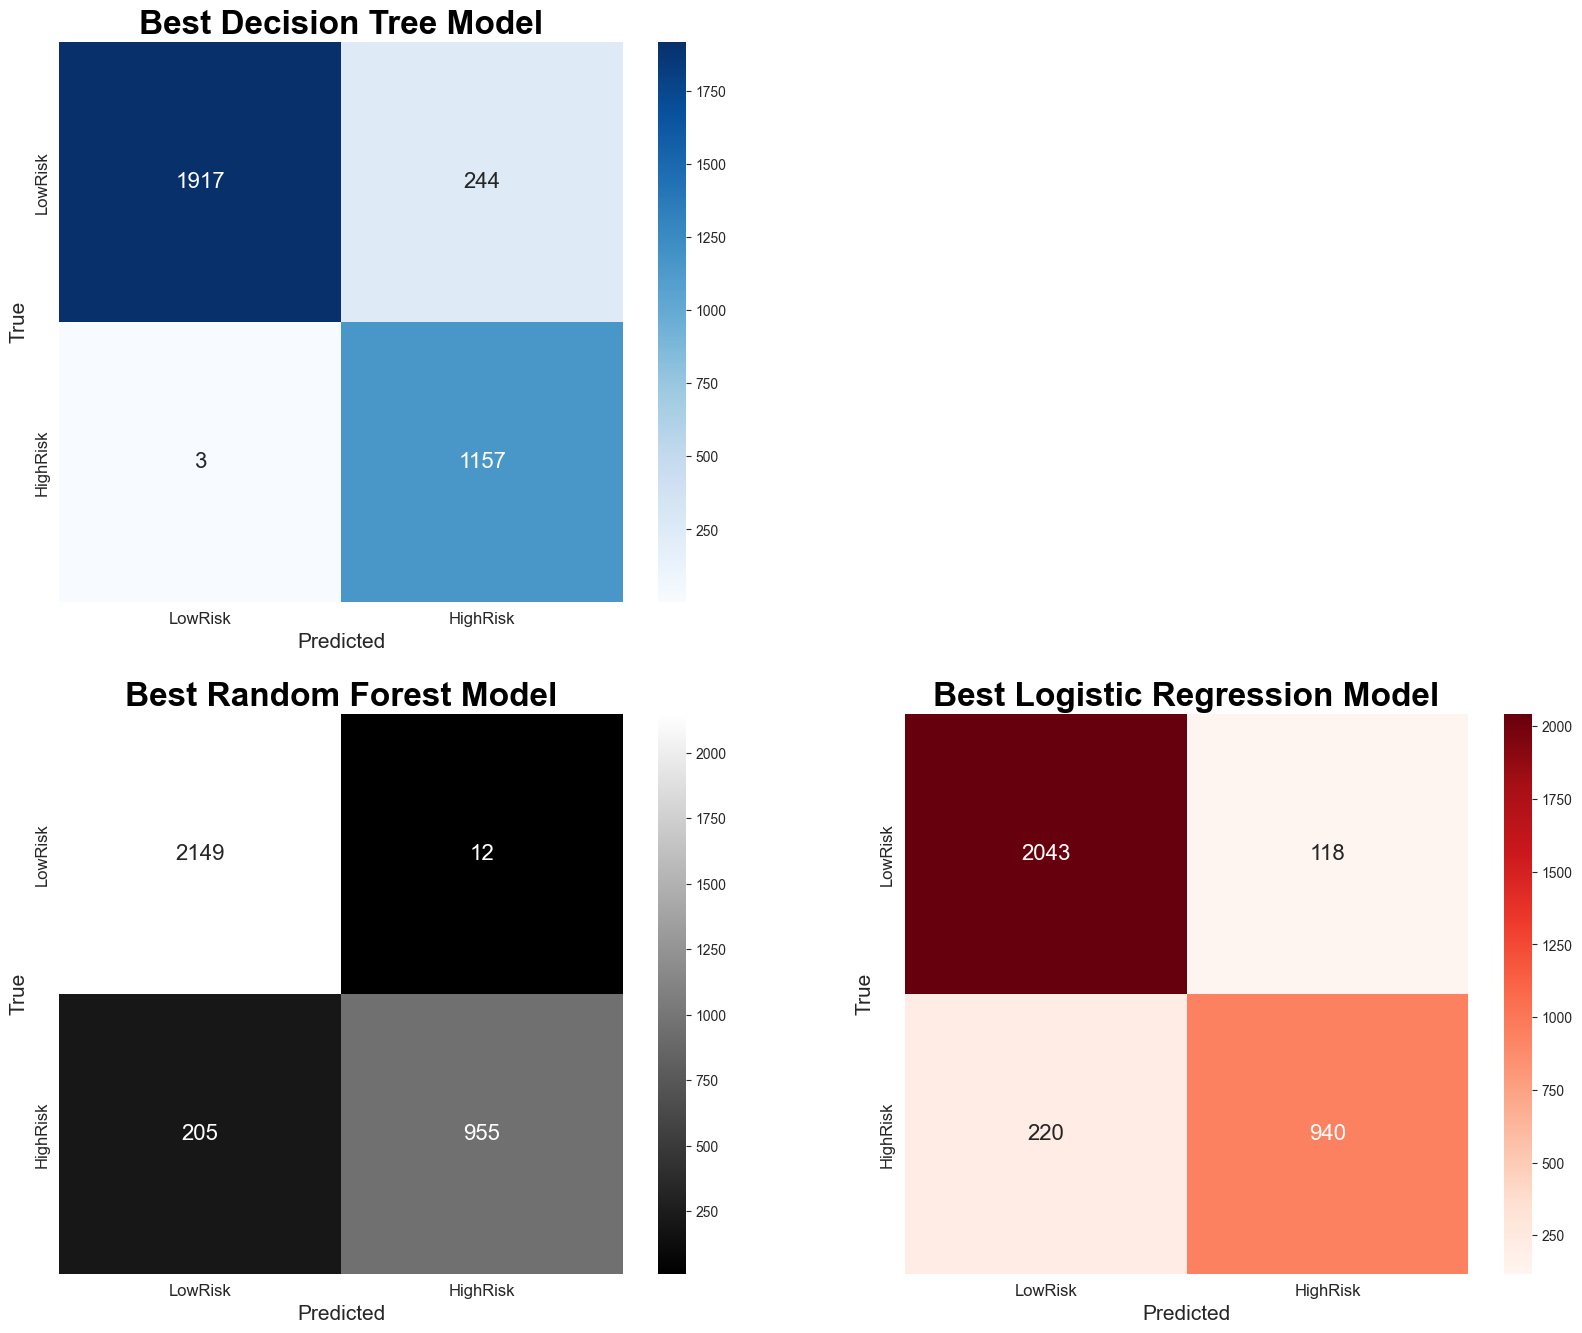

In [71]:
plt.figure(figsize=(20,16))


plt.subplot(221)
plt.title('Best Decision Tree Model', fontweight='bold', color = 'black', fontsize='24', horizontalalignment='center')
dt_chart = sns.heatmap(dt_conf_matrix, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
dt_chart.set_xlabel('Predicted', fontsize=15)
dt_chart.set_ylabel('True', fontsize=15)
dt_chart.xaxis.set_ticklabels(['LowRisk', 'HighRisk'], fontsize=12)
dt_chart.yaxis.set_ticklabels(['LowRisk', 'HighRisk'], fontsize=12, va='center')


plt.subplot(223)
plt.title('Best Random Forest Model', fontweight='bold', color = 'black', fontsize='24', horizontalalignment='center')
rf_chart = sns.heatmap(rf_conf_matrix, annot=True, cmap="gist_gray", annot_kws={"size": 16}, fmt="g")
rf_chart.set_xlabel('Predicted', fontsize=15)
rf_chart.set_ylabel('True', fontsize=15)
rf_chart.xaxis.set_ticklabels(['LowRisk', 'HighRisk'], fontsize=12)
rf_chart.yaxis.set_ticklabels(['LowRisk', 'HighRisk'], fontsize=12, va='center')


plt.subplot(224)
plt.title('Best Logistic Regression Model', fontweight='bold', color = 'black', fontsize='24', horizontalalignment='center')
lr_chart = sns.heatmap(lr_conf_matrix, annot=True, cmap="Reds", annot_kws={"size": 16}, fmt="g")
lr_chart.set_xlabel('Predicted', fontsize=15)
lr_chart.set_ylabel('True', fontsize=15)
lr_chart.xaxis.set_ticklabels(['LowRisk', 'HighRisk'], fontsize=12)
lr_chart.yaxis.set_ticklabels(['LowRisk', 'HighRisk'], fontsize=12, va='center')
plt.show()

say which one is better and why
* dec tree bc better acc and we're focused on predicting high risk not low risk so sensitivity is more important than specivity

## Most Important Variables Across Models
1. TotalPaid:
    * This variable consistently appears as one of the most important predictors in the Random Forest, Decision Tree and Logistic Regression models. This variable captures the financial impact of claims and reflects how much has been paid out for a customer's claims.  Customers with high TotalPaid amounts are more likely categorized as high-risk.    
    
2. ClaimTransCount:
    * Another strong predictor across all three models, this variable represents the number of transactions associated with claims. A higher count could indicate a pattern of frequent claim-related activities, correlating with higher risk.  
    
3. Insured at Fault:
    * The variable 'AtFaultDescription_Insured at fault' appears consistently as a significant predictor in all models. This factor likely emphasizes behavioral patterns or responsibility in claims, with customers frequently at fault being more prone to high-risk classification.
    
* **Supporting Variables**
    * Claim Count: This was found as an important predictor in all models, particularly in the Decision Tree and Logistic Regression. This variable reflects the total number of claims filed, which is often an indicator of customer risk level.
    * ClaimTransPaidLoss: While not as consistently ranked as the top feature, this variable holds importance in the Random Forest and Logistic Regression models, emphasizing the loss amounts per transaction.
    
    
- **Conclusion**
    - The overall top features: **TotalPaid, ClaimTransCount, and Insured at Fault**, demonstrate that both financial impact and behaviorial patterns are critical in assessing whether a customer is high risk. The inclusion of these variables in all three models highlight their reliability and effectiveness in predictive analytics for risk assessment.










## Summary
* To identify high-risk customers, I employeed three classification models: Decision Tree, Logistic Regression, and Random Forest. These models were evaluated based on key performance metrics including accuracy, sensitivity, specificity, the confusion matrix, and the ROC curve. By analyzing these metrics, I was able to determine the most suitable model for predicting whether a customer is high risk (1) or not(0).

- **Evaluation Metrics Overview**
    1. **Accuracy**: Measures the overall correctness of the model in classifying both high-risk and low-risk customers. It is the ratio of correctly classified instances (both positive and negative) to the total number of instances.
        * Decision Tree: 0.93
        * Random Forest: 0.93
        * Logistic Regression: 0.90
        
    2. **Sensitivity**: Indicates the model's ability to correctly identify high-risk customers (true positives). This metric is particularly important as the goal is to prioritize identifying high-risk customers over low-risk ones.
        * Decision Tree: 1.00
        * Random Forest: 0.82
        * Logistic Regression: 0.81

    3. **Specificity**: Measures the model's ability to correctly classify low-risk customers (true negatives). While specificity is important to reduce false positives, it is less critical in this scenario compared to sensitivity.
        * Decision Tree: 0.89
        * Random Forest: 0.99
        * Logistic Regression: 0.95
        
        
* **Model Selection**
    * After careful consideration, I determined that the **Decision Tree model** was the best fit model for predicting high-risk customers. This conclusion was based on the following observations
        * The Decision Tree achieved the **same accuracy (93%)** as the Random Forest model, which indicates that both models are highly effective overall.
        * It demonstrated **higher sensitivity (100%)** compared to the Random Forest (82%) and Logistic Regression (81%). This is crucial because the objective is to accurately identify high-risk customers (1), in otherwords, minimizing false negatives.
        * While the Decision Tree's specificity (89%) was lower than the Random Forest's (99%), it still performed very well in identifying low-risk customers. This slight trade-off in specificity is acceptable given the priority on evaluating high-risk customers.
        
- **Insights and Conclusions**
    - The Decision Tree model's ability to balance high sensitivity with strong specificity makes it the most effective model for the task. It ensures the majority of high-risk customers are identified while maintaining low misclassification rates for low-risk customers
    - The Random FOrest model, although comparable in accuracy, was less sensitive to high-risk customers, making it less suited for this specific case. However, if the goal was to identify low-risk customers, this would be the ideal model.
    - Logistic Regression, while similar and faster to train, lagged behind in both accuracy and sensitivity, indicating it was not capable of capturing the complexities of the dataset.  
    
In conclusion, this analysis underscores the importance of prioritizing sensitivity in scenarios where identifying high-risk individuals is critical. The Decision Tree model's performance highlights its strength in achieving this goal, making it the optimal choize for predicting high-risk customers.
    
    


        